In [86]:
import os
from numpy import dtype
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio

class AiShellDataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        transcript_file = data_path+'transcript/aishell_transcript_v0.8.txt'
        self.transcript = self.gen_transcript(transcript_file)
        self.wav_files = self.get_all_wav_files(data_path, self.transcript)
        self.dataset_file_num = len(self.wav_files)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 120000 # to avoid GPU memory used out
        self.batch_size = 80 # to avoid GPU memory used out
        self.split_ratio = [1000, 1]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_name = self.wav_files[idx]
        waveform, sample_rate = torchaudio.load(audio_name)
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        dict_id = audio_name.rsplit('/',1)[-1].split('.')[0]
        audio_content = self.transcript[dict_id]
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def parse_line(self, line):
        id, text = line.split(' ', 1)
        text = ''.join(text.split(' '))
        return id, text

    def gen_transcript(self, transcript_file):
        transcript = {}
        with open(transcript_file, 'r') as f:
            content = f.read()
            lines = content.split('\n')[:-1]
            for line in lines:
                id, text = self.parse_line(line)
                transcript[id] = text
        return transcript

    def get_all_wav_files(self, path, transcript):
        folders = []
        train = os.listdir(path+'wav/train/')
        folders += [path+'wav/train/'+i for i in train]
        dev = os.listdir(path+'wav/dev/')
        folders += [path+'wav/dev/'+i for i in dev]
        test = os.listdir(path+'wav/test/')
        folders += [path+'wav/test/'+i for i in test]
        files = []
        for folder in folders:
            files += [folder+'/'+i for i in os.listdir(folder) if i[:-4] in transcript]
        return files
    
    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [87]:
if __name__ == '__main__':
    # dataset = AudioDataset('./data/ST-CMDS-20170001_1-OS/')
    dataset = AiShellDataset('./data/data_aishell/')
    batch_size = 8
    train_set, test_set = dataset.split([1000, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 140895 test_set: 705
torch.Size([8, 88087]) torch.Size([8, 69])
torch.Size([8, 96348]) torch.Size([8, 72])
torch.Size([6, 86609]) torch.Size([6, 69])
torch.Size([8, 97678]) torch.Size([8, 93])
torch.Size([7, 85789]) torch.Size([7, 68])
torch.Size([7, 95672]) torch.Size([7, 71])
torch.Size([8, 104533]) torch.Size([8, 82])
torch.Size([8, 106464]) torch.Size([8, 96])
torch.Size([8, 112501]) torch.Size([8, 86])
torch.Size([8, 99767]) torch.Size([8, 81])
torch.Size([7, 87598]) torch.Size([7, 90])
torch.Size([8, 82148]) torch.Size([8, 68])


In [82]:
dataset = AiShellDataset('./data/data_aishell/')
lens = [dataset[i]['audio'].shape[-1] for i in range(500)]

In [84]:
lens2 = [dataset[i+500]['audio'].shape[-1] for i in range(1000)]

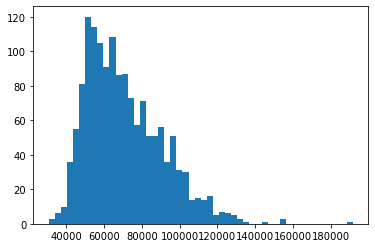

In [85]:
import matplotlib.pyplot as plt
plt.hist(lens+lens2, bins = 50)
plt.show()